In [45]:
library(Seurat)
library(SeuratData)
library(patchwork)
library(conos)
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:ensembldb':

    filter, select


The following object is masked from 'package:AnnotationDbi':

    select


The following object is masked from 'package:Biobase':

    combine


The following objects are masked from 'package:GenomicRanges':

    intersect, setdiff, union


The following object is masked from 'package:GenomeInfoDb':

    intersect


The following objects are masked from 'package:IRanges':

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from 'package:S4Vectors':

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from 'package:BiocGenerics':

    combine, intersect, setdiff, union


The following object is masked from 'package:biomaRt':

    select


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


Th

## Data descriptions 
The analysis contains data from different samples. Briefly the dataset contains
### Mouse NB (New)
#### Tumor
The tumor samples - `/home/meisl/Workplace/neuroblastoma/ThMYCN_210610/conos/conos/all.tumor_conos.rds`
```
'het1_tumor''het2_tumor''homo1_tumor''homo2_tumor''homo3_tumor'
```
#### BM (should contain one more sample)
The BM samples - `/home/meisl/Workplace/neuroblastoma/ThMYCN_210610/conos/conos/all.bm_conos.rds`
```
'het1_bm''het2_bm''homo1_bm''homo2_bm''wt1_bm''wt2_bm''wt3_bm'
```
### Human NB (old)

The viable cells 
NB01-26, NB34, NB36 `/home/meisl/Workplace/neuroblastoma/Figures/data/scon.new.conos.rds`

Annotation `/home/meisl/Workplace/neuroblastoma/Figures/data/newano.rds`

Nuc-Seq `/home/meisl/Workplace/neuroblastoma/Figures/data/nucseq`

### Public data
#### Mouse adrenal samples 
```
'adrenal_70' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067113_10x70.raw_feature_bc_matrix.h5',
'adrenal_71' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067114_10x71.raw_feature_bc_matrix.h5',
'adrenal_72' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067115_10x72.raw_feature_bc_matrix.h5'
```



## Make Seurat objects for (5 Tumor samples)

In [2]:
tumor.con = readRDS('/home/meisl/Workplace/neuroblastoma/ThMYCN_210610/conos/conos/all.tumor_conos.rds')

In [3]:
raw.count.objs = lapply(tumor.con$samples, function(x){
  raw.count = x$misc$rawCounts
  mito.genes = grep(pattern = "^mt-", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rpl.genes = grep(pattern = "^rpl", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rps.genes = grep(pattern = "^rps", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  genes.removed = union(mito.genes, rpl.genes)
  genes.removed = union(genes.removed, rps.genes)
  
  t(raw.count[, setdiff(colnames(raw.count), genes.removed) ])
})

In [4]:
names(raw.count.objs)

[1] "het1_tumor"  "het2_tumor"  "homo1_tumor" "homo2_tumor" "homo3_tumor"

In [5]:
seurat.obj.list = lapply(names(raw.count.objs),function(sample.name)  CreateSeuratObject(
    counts = raw.count.objs[[sample.name]], 
    project = paste("mnb5",sample.name, sep="_"), 
    min.cells = 3, 
    min.features = 500
))

In [6]:
names(seurat.obj.list) = names(raw.count.objs)

In [7]:
seurat.obj.list <- lapply(X = seurat.obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [ ]:
features <- SelectIntegrationFeatures(object.list = seurat.obj.list)

## Perform integration

In [25]:
neuro.anchors <- FindIntegrationAnchors(object.list = seurat.obj.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 22128 anchors

Filtering anchors

	Retained 7476 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 23959 anchors

Filtering anchors

	Retained 8593 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 17849 anchors

Filtering anchors

	Retained 5269 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13438 anchors

Filtering anchors

	Retained 7506 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12471 anchors

Filtering anchors

	Retained 6435 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 12133 anchors

Filtering anchors

	Retained 7277 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 33309 anchors

Filtering anchors

	Retained 

In [27]:
neuro.combined <- IntegrateData(anchorset = neuro.anchors)

Merging dataset 4 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 1 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 into 1 4 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 5 into 1 4 3 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



## Perform Integrated Analysis

In [28]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(neuro.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
neuro.combined <- ScaleData(neuro.combined, verbose = FALSE)
neuro.combined <- RunPCA(neuro.combined, npcs = 30, verbose = FALSE)
neuro.combined <- RunUMAP(neuro.combined, reduction = "pca", dims = 1:30)
neuro.combined <- FindNeighbors(neuro.combined, reduction = "pca", dims = 1:30)
neuro.combined <- FindClusters(neuro.combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
19:05:32 UMAP embedding parameters a = 0.9922 b = 1.112

19:05:32 Read 40044 rows and found 30 numeric columns

19:05:32 Using Annoy for neighbor search, n_neighbors = 30

19:05:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:05:38 Writing NN index file to temp file /tmp/RtmpadQT7M/file43fd38fc9439

19:05:38 Searching Annoy index using 1 thread, search_k = 3000

19:05:53 Annoy recall = 100%

19:05:54 Commencing smooth kNN distance calibration using 1 thread

19:05:57 Initializing fr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 40044
Number of edges: 1325559

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8923
Number of communities: 18
Elapsed time: 9 seconds


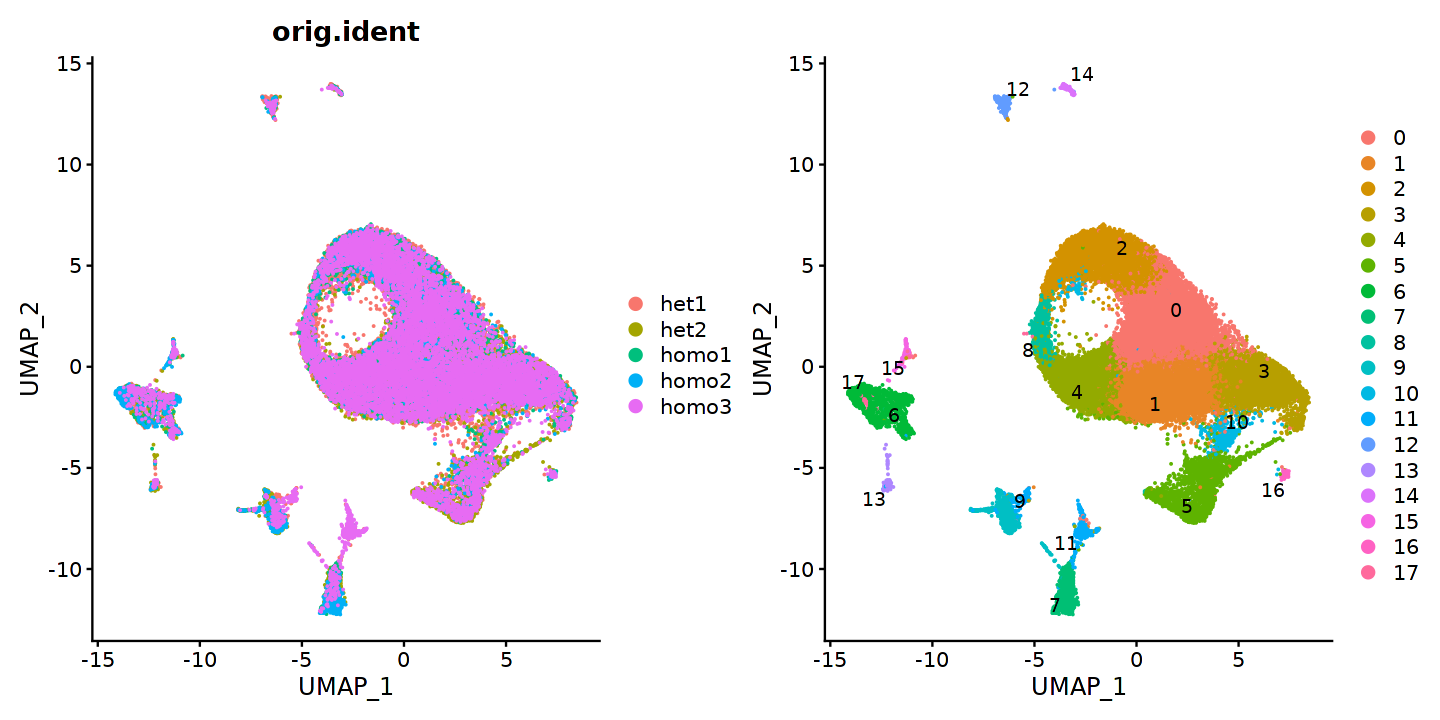

In [38]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(neuro.combined, reduction = "umap", group.by = 'orig.ident')
p2 <- DimPlot(neuro.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

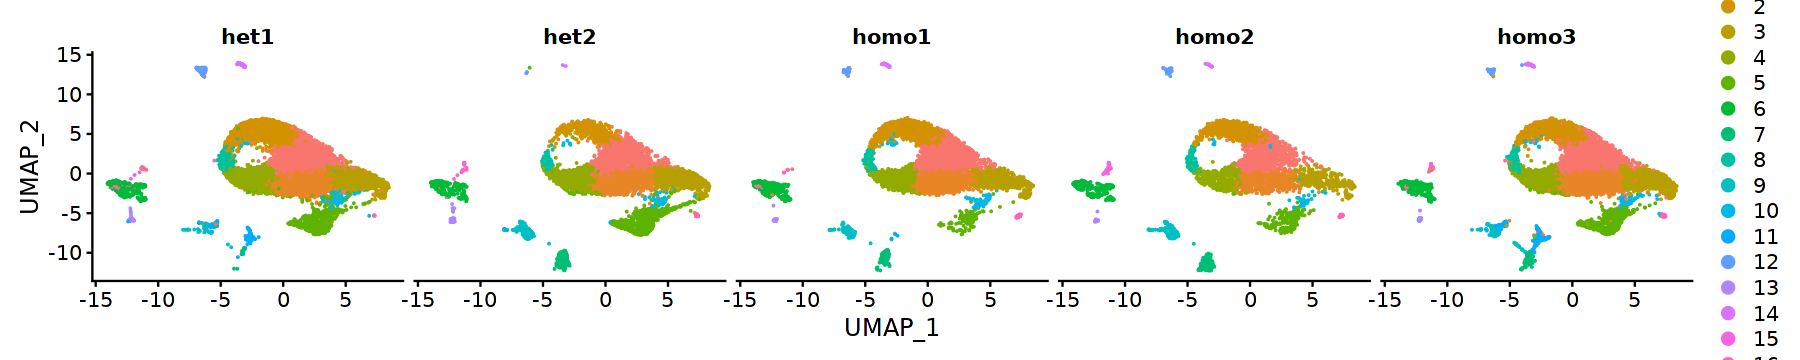

In [41]:
options(repr.plot.height=3, repr.plot.width=15, res=150 ) 
DimPlot(neuro.combined, reduction = "umap", split.by = "orig.ident")

In [57]:
saveRDS(neuro.combined, '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat/mouse_nb_5_samples_seurat.rds')

In [2]:
neuro.combined = readRDS('/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat/mouse_nb_5_samples_seurat.rds')

## Create allele specific samples

In [3]:
het_indices = grep("het", neuro.combined$orig.ident)
homo_indices = grep("homo", neuro.combined$orig.ident)

In [4]:
allele_type = neuro.combined$orig.ident

In [5]:
allele_type[het_indices] = "het"
allele_type[homo_indices] = "homo"

In [16]:
neuro.combined$allele = allele_type

In [17]:
ifnb.list <- SplitObject( neuro.combined , split.by = "allele")

In [18]:
# select features that are repeatedly variable across datasets for integration
features <- SelectIntegrationFeatures(object.list = ifnb.list)

In [20]:
length(ifnb.list)

[1] 2

In [21]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)
# this command creates an 'integrated' data assay
immune.combined <- IntegrateData(anchorset = immune.anchors)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 53234 anchors

Filtering anchors

	Retained 14306 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [22]:
# specify that we will perform downstream analysis on the corrected data note that the
# original unmodified data still resides in the 'RNA' assay
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:21:29 UMAP embedding parameters a = 0.9922 b = 1.112

21:21:29 Read 40044 rows and found 30 numeric columns

21:21:29 Using Annoy for neighbor search, n_neighbors = 30

21:21:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:21:35 Writing NN index file to temp file /tmp/RtmpDZjcEO/file8d61511ad3d8

21:21:35 Searching Annoy index using 1 thread, search_k = 3000

21:21:50 Annoy recall = 100%

21:21:50 Commencing smooth kNN distance calibration using 1 thread

21:21:53 Initializing fr

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 40044
Number of edges: 1347276

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 21
Elapsed time: 9 seconds


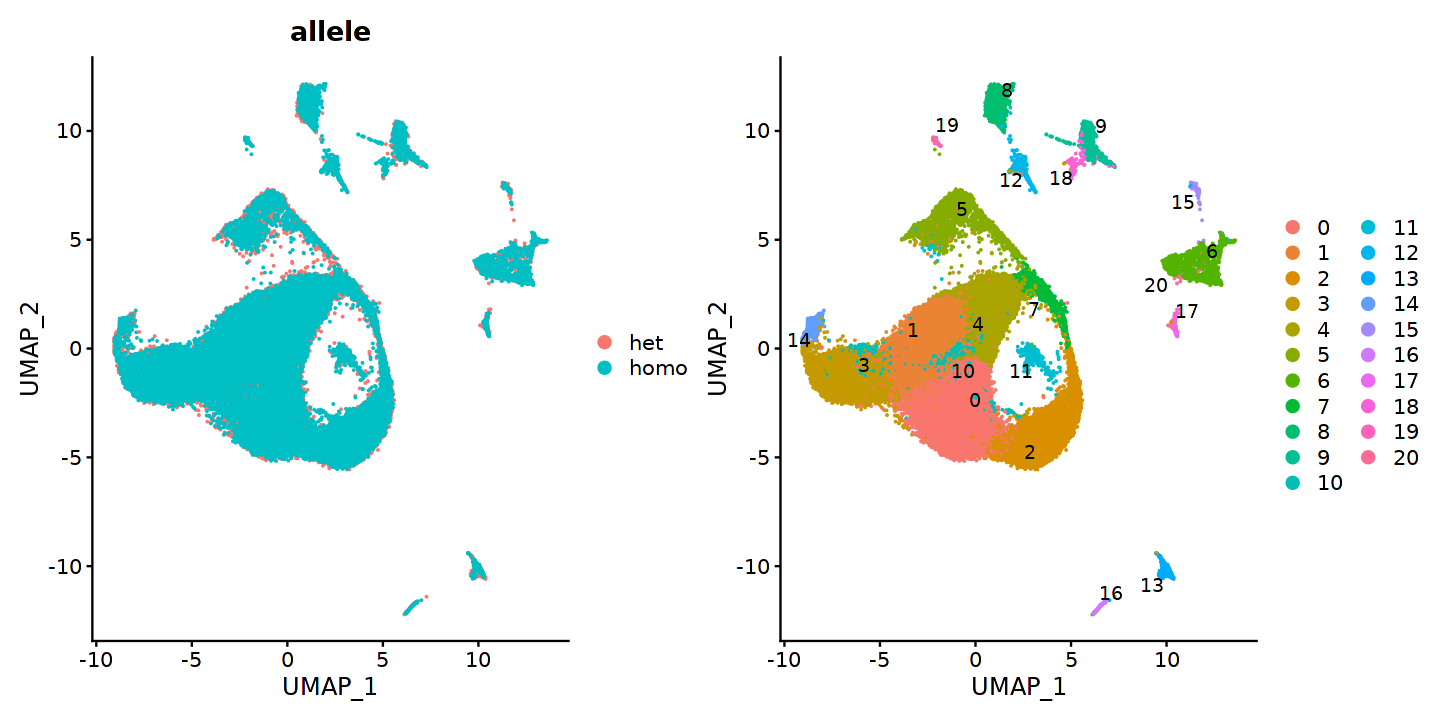

In [23]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = 'allele')
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

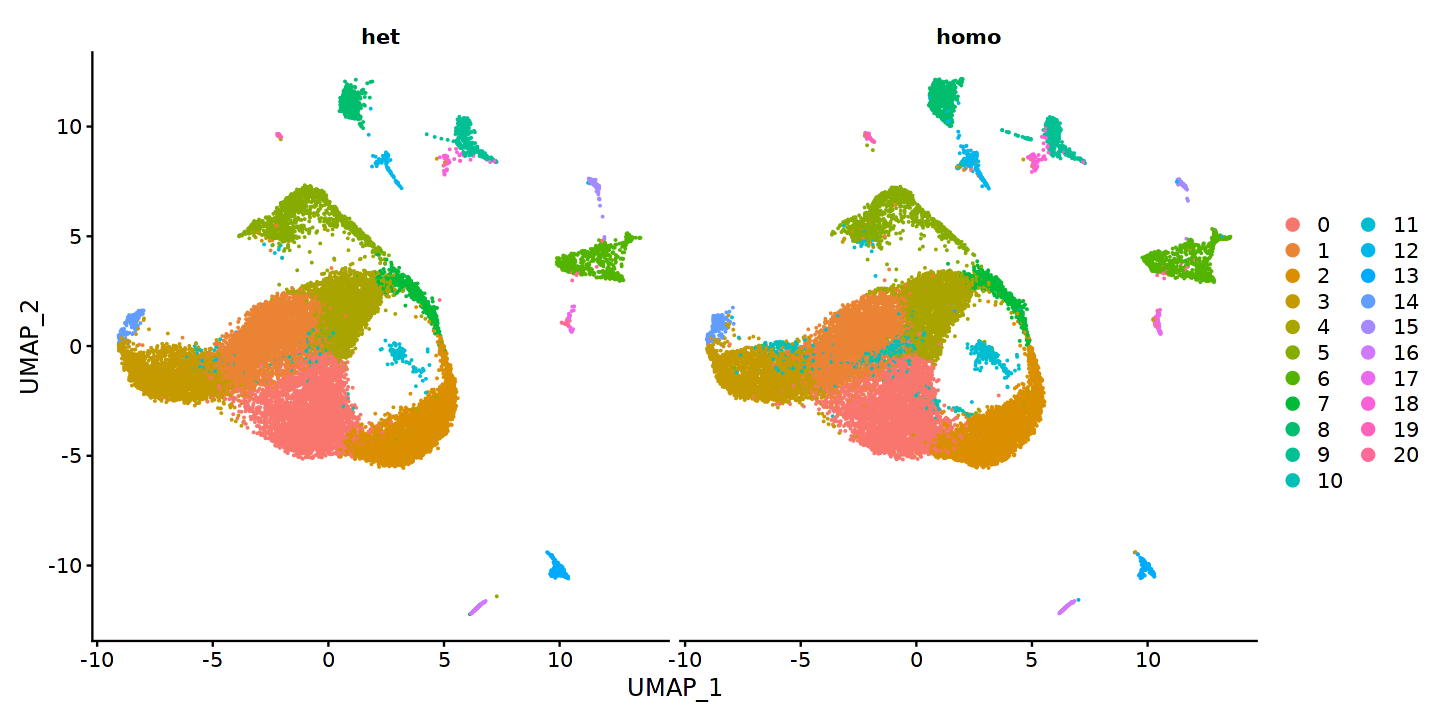

In [24]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
DimPlot(immune.combined, reduction = "umap", split.by = "allele")

## Project Conos clusters (5 samples)

In [25]:
anot.5 = read.csv('/home/hsarkar/Projects/ThMYCN/annotation_5_samples.csv')

In [28]:
colnames(anot.5) = c('cell.id','clusters')

In [30]:
annotation = as.factor(anot.5$clusters)
names(annotation) = anot.5$cell.id

In [31]:
immune.combined$clusters = annotation

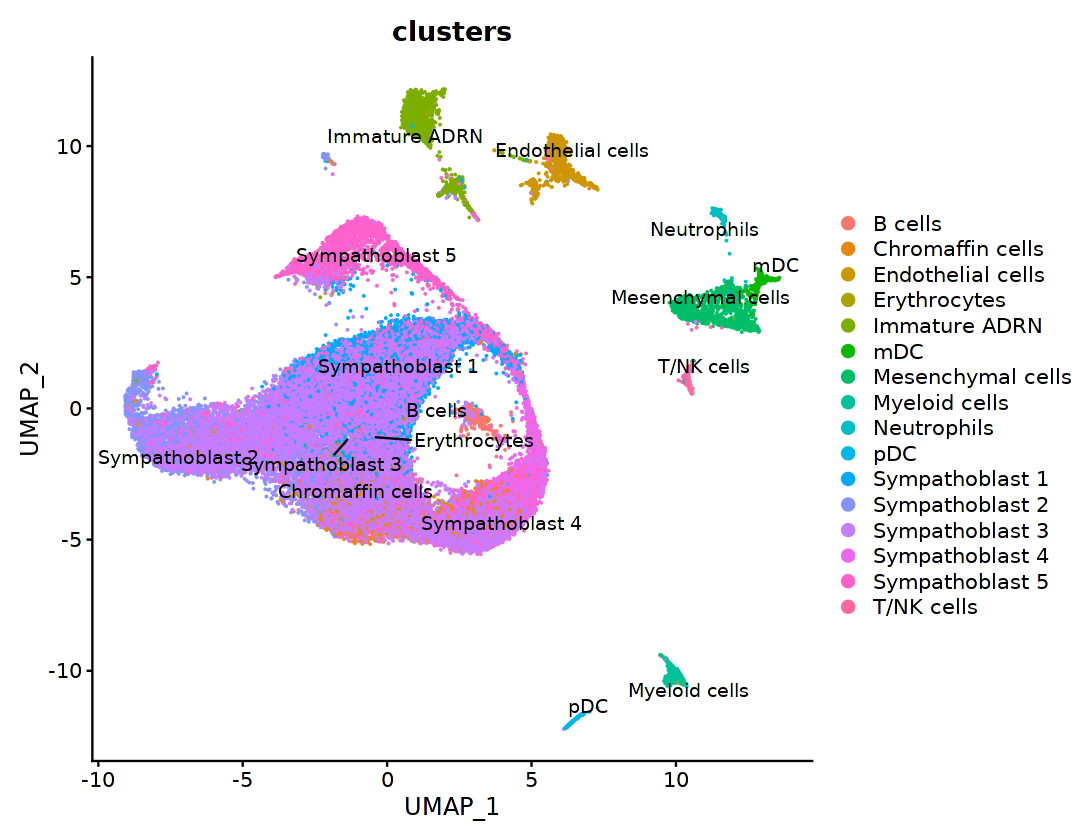

In [36]:
options(repr.plot.height=7, repr.plot.width=9, res=150 ) 
DimPlot(immune.combined, reduction = "umap", group.by = "clusters",label = TRUE, repel = TRUE)

## Add more samples

In [37]:
file.names = c(
'adrenal_70' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067113_10x70.raw_feature_bc_matrix.h5',
'adrenal_71' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067114_10x71.raw_feature_bc_matrix.h5',
'adrenal_72' = '/home/hsarkar/Projects/ThMYCN/PMID33833454/GSM5067115_10x72.raw_feature_bc_matrix.h5'
)

In [48]:
raw.objs = lapply(names(file.names), function(fname){
  f = file.names[[fname]]
  raw.count = Read10X_h5(f)
  colnames(raw.count) = paste(fname, colnames(raw.count), sep="_")
  
  mito.genes = grep(pattern = "^mt-", x = rownames(raw.count), value = TRUE, ignore.case = TRUE)
  rpl.genes = grep(pattern = "^rpl", x = rownames(raw.count), value = TRUE, ignore.case = TRUE)
  rps.genes = grep(pattern = "^rps", x = rownames(raw.count), value = TRUE, ignore.case = TRUE)
  genes.removed = union(mito.genes, rpl.genes)
  genes.removed = union(genes.removed, rps.genes)
  
  raw.count[setdiff(rownames(raw.count), genes.removed), ]
})
names(raw.objs) = names(file.names)

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”


In [49]:
seurat.adrenal.obj.list = lapply(names(raw.objs),function(sample.name)  CreateSeuratObject(
    counts = raw.objs[[sample.name]],
    min.cells = 3, 
    min.features = 500
))

In [50]:
names(seurat.adrenal.obj.list) = names(raw.objs)

In [52]:
seurat.adrenal.obj.list <- lapply(X = seurat.adrenal.obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [53]:
head(seurat.adrenal.obj.list[[1]]$orig.ident)

adrenal_70_AAACCCAAGAGGCTGT-1 adrenal_70_AAACCCAAGGATGCGT-1 
                      adrenal                       adrenal 
adrenal_70_AAACCCAAGGCTATCT-1 adrenal_70_AAACCCAAGGGCAACT-1 
                      adrenal                       adrenal 
adrenal_70_AAACCCACAACGCCCA-1 adrenal_70_AAACCCACATAGAGGC-1 
                      adrenal                       adrenal 
Levels: adrenal

In [54]:
tumor.adrenal.combined = merge(seurat.obj.list[[1]], 
                               y = c(seurat.obj.list[2:5], seurat.adrenal.obj.list), 
                               merge.data = T)

In [57]:
combined.annotation = tumor.adrenal.combined$orig.ident

In [63]:
combined.annotation[!grepl("adrenal",tumor.adrenal.combined$orig.ident)] = 'tumor'
combined.annotation[grepl("adrenal",tumor.adrenal.combined$orig.ident)] = 'adrenal'

In [64]:
tumor.adrenal.combined$condition = combined.annotation

In [65]:
ifnb.list <- SplitObject( tumor.adrenal.combined , split.by = "condition")

In [66]:
features <- SelectIntegrationFeatures(object.list = ifnb.list)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



In [ ]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)
immune.combined <- IntegrateData(anchorset = immune.anchors)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 36784 anchors

Filtering anchors



In [ ]:
DefaultAssay(immune.combined) <- "integrated"

# Run the standard workflow for visualization and clustering
immune.combined <- ScaleData(immune.combined, verbose = FALSE)
immune.combined <- RunPCA(immune.combined, npcs = 30, verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:30)
immune.combined <- FindClusters(immune.combined, resolution = 0.5)

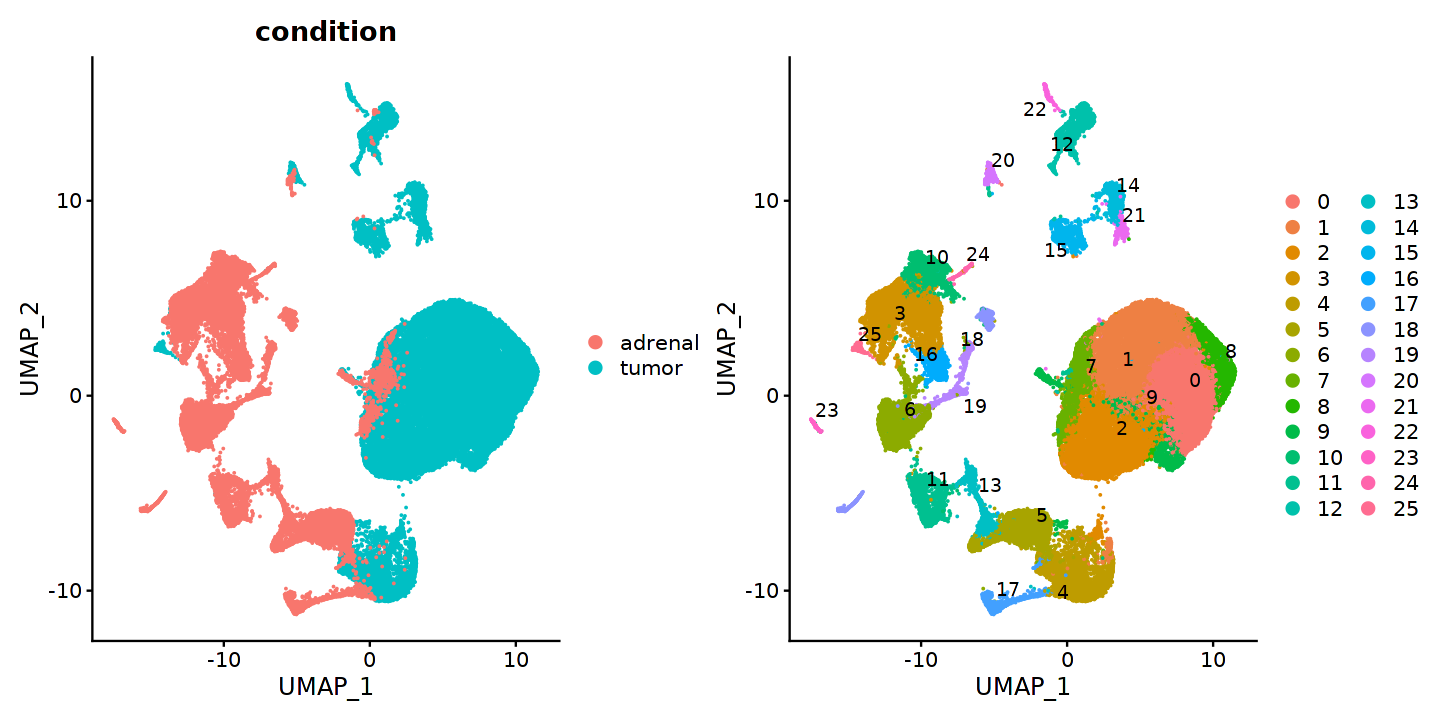

In [70]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(immune.combined, reduction = "umap", group.by = "condition")
p2 <- DimPlot(immune.combined, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

## Project Conos annotation (8 samples)

In [71]:
conos.8 = readRDS('/home/hsarkar/Projects/ThMYCN/combined_conos_app_v2_conos.rds')
annotations = openxlsx::read.xlsx('/home/hsarkar/Projects/ThMYCN/Sheets/combined_diff_up_reg_v2 - Annotations.xlsx')
annotations = annotations$Annotation

In [74]:
tmp = conos.8$clusters$leiden$groups 
conos.8$clusters$leiden$groups  = annotations[tmp]
names(conos.8$clusters$leiden$groups) = names(tmp)
conos.8$clusters$leiden$groups = as.factor(conos.8$clusters$leiden$groups)

In [83]:
annot.8 = conos.8$clusters$leiden$groups

In [143]:
names(annot.8) = sub('(^[^_]+_[^_]+)_(.*)$', '\\2', names(annot.8))

In [144]:
immune.combined$clusters = annot.8

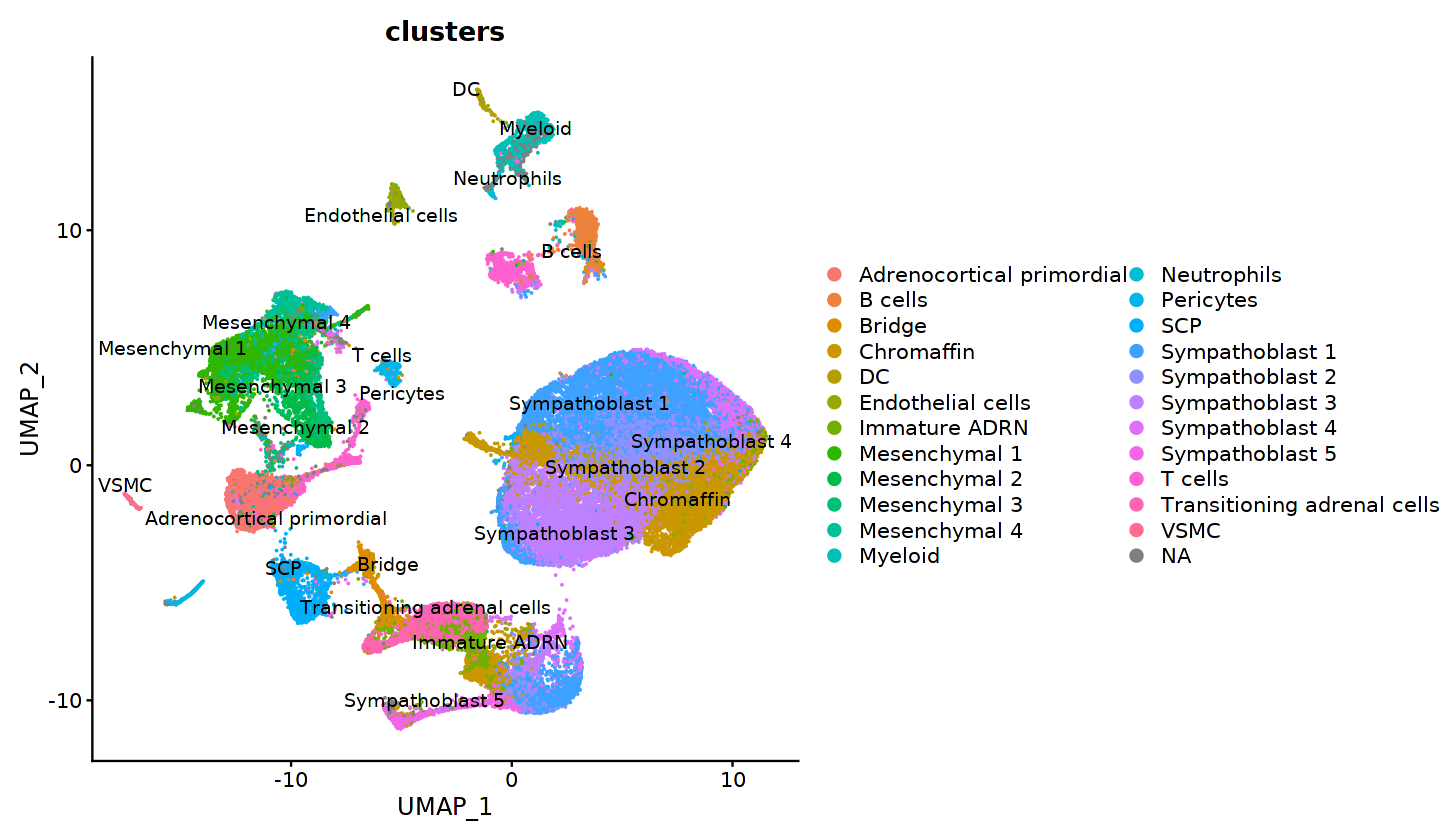

In [147]:
options(repr.plot.height=7, repr.plot.width=12, res=150 ) 
DimPlot(immune.combined, reduction = "umap", group.by = "clusters",label = TRUE, repel = TRUE)

In [148]:
saveRDS(immune.combined, '/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat/mouse_nb_8_samples_seurat.rds')

### Regressing out the cell-cycles genes

In [41]:
#cc_file <- getURL("https://raw.githubusercontent.com/hbc/tinyatlas/master/cell_cycle/Mus_musculus.csv") 
cell_cycle_genes <- read.csv(text = '../data//Mus_musculus.csv')

In [42]:
# Connect to AnnotationHub
require(ensembldb)
ah <- AnnotationHub()

# Access the Ensembl database for organism
ahDb <- query(ah, 
              pattern = c("Homo sapiens", "EnsDb"), 
              ignore.case = TRUE)

# Acquire the latest annotation files
id <- ahDb %>%
        mcols() %>%
        rownames() %>%
        tail(n = 1)

# Download the appropriate Ensembldb database
edb <- ah[[id]]

# Extract gene-level information from database
annotations <- genes(edb, 
                     return.type = "data.frame")

# Select annotations of interest
annotations <- annotations %>%
        dplyr::select(gene_id, gene_name, seq_name, gene_biotype, description)

Loading required package: ensembldb

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:igraph’:

    normalize, path, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, whic

ERROR: Error in AnnotationHub(): could not find function "AnnotationHub"


In [37]:
# Basic function to convert human to mouse gene names
convertHumanGeneList <- function(x){
    require("biomaRt")
    human = useMart("ensembl", dataset = "hsapiens_gene_ensembl")
    mouse = useMart("ensembl", dataset = "mmusculus_gene_ensembl")

    genesV2 = getLDS(attributes = c("hgnc_symbol"), filters = "hgnc_symbol", values = x , mart = human, attributesL = c("mgi_symbol"), martL = mouse, uniqueRows=T)

    humanx <- unique(genesV2[, 2])

    # Print the first 6 genes found to the screen
    print(head(humanx))
    return(humanx)
}

In [38]:
convertHumanGeneList(cc.genes$s.genes)

Loading required package: biomaRt

Ensembl site unresponsive, trying useast mirror



ERROR: Error in curl::curl_fetch_memory(url, handle = handle): SSL certificate problem: unable to get local issuer certificate


In [34]:
seurat.8 = readRDS('/home/hsarkar/Projects/neuroblastoma_analysis/results/seurat/mouse_nb_8_samples_seurat.rds')

In [31]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [35]:
SR <- CellCycleScoring(seurat.8, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

Warning message:
“The following features are not present in the object: MCM5, PCNA, TYMS, FEN1, MCM2, MCM4, RRM1, UNG, GINS2, MCM6, CDCA7, DTL, PRIM1, UHRF1, MLF1IP, HELLS, RFC2, RPA2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, MSH2, ATAD2, RAD51, RRM2, CDC45, CDC6, EXO1, TIPIN, DSCC1, BLM, CASP8AP2, USP1, CLSPN, POLA1, CHAF1B, BRIP1, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HMGB2, CDK1, NUSAP1, UBE2C, BIRC5, TPX2, TOP2A, NDC80, CKS2, NUF2, CKS1B, MKI67, TMPO, CENPF, TACC3, FAM64A, SMC4, CCNB2, CKAP2L, CKAP2, AURKB, BUB1, KIF11, ANP32E, TUBB4B, GTSE1, KIF20B, HJURP, CDCA3, HN1, CDC20, TTK, CDC25C, KIF2C, RANGAP1, NCAPD2, DLGAP5, CDCA2, CDCA8, ECT2, KIF23, HMMR, AURKA, PSRC1, ANLN, LBR, CKAP5, CENPE, CTCF, NEK2, G2E3, GAS2L3, CBX5, CENPA, not searching for symbol synonyms”
Warning message in AddModuleScore(object = object, features = features, name = name, :
“Could not find enough features in the object 

## Combine human and mouse

### Rename the mouse genes names (they are not capitalized)

In [8]:
raw.count.objs = lapply(tumor.con$samples, function(x){
  raw.count = x$misc$rawCounts
  mito.genes = grep(pattern = "^mt-", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rpl.genes = grep(pattern = "^rpl", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rps.genes = grep(pattern = "^rps", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  genes.removed = union(mito.genes, rpl.genes)
  genes.removed = union(genes.removed, rps.genes)
    
  raw.count = raw.count[, setdiff(colnames(raw.count), genes.removed) ]
  colnames(raw.count) = toupper(colnames(raw.count))  
  
  t(raw.count)
})

seurat.obj.list = lapply(names(raw.count.objs),function(sample.name)  CreateSeuratObject(
    counts = raw.count.objs[[sample.name]], 
    project = paste("mnb5",sample.name, sep="_"), 
    min.cells = 3, 
    min.features = 500
))

names(seurat.obj.list) = names(raw.count.objs)
seurat.obj.list <- lapply(X = seurat.obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”


In [9]:
human.conos = readRDS('/home/meisl/Workplace/neuroblastoma/Figures/data/scon.new.conos.rds')

In [10]:
raw.count.objs = lapply(human.conos$samples, function(x){
  raw.count = x$misc$rawCounts
  mito.genes = grep(pattern = "^mt-", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rpl.genes = grep(pattern = "^rpl", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  rps.genes = grep(pattern = "^rps", x = colnames(raw.count), value = TRUE, ignore.case = TRUE)
  genes.removed = union(mito.genes, rpl.genes)
  genes.removed = union(genes.removed, rps.genes)
  
  t(raw.count[, setdiff(colnames(raw.count), genes.removed) ])
})

In [11]:
names(raw.count.objs)

[1] "NB26" "NB01" "NB02" "NB09" "NB11" "NB12" "NB13" "NB15" "NB16" "NB17"
[11] "NB18" "NB19" "NB20" "NB21" "NB22" "NB23" "NB24" "NB34" "NB37"

In [12]:
raw.count.objs[[1]][1:2,1:2]

2 x 2 sparse Matrix of class "dgCMatrix"
            NB26_AAACCTGAGATATGGT-1 NB26_AAACCTGAGGATGTAT-1
MIR1302-2HG                       .                       .
FAM138A                           .                       .

In [13]:
seurat.human.obj.list = lapply(names(raw.count.objs),function(sample.name)  CreateSeuratObject(
    counts = raw.count.objs[[sample.name]],
    min.cells = 3, 
    min.features = 500
))

In [14]:
names(seurat.human.obj.list) = names(raw.count.objs)

In [15]:
seurat.human.obj.list <- lapply(X = seurat.human.obj.list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})

In [16]:
mouse.human.combined = merge(seurat.obj.list[[1]], 
                               y = c(seurat.obj.list[2:5], seurat.human.obj.list ), 
                               merge.data = T)

In [17]:
mouse.human = mouse.human.combined$orig.ident

In [18]:
mouse.human[!grepl("NB", mouse.human.combined$orig.ident)] = 'mouse'
mouse.human[grepl("NB", mouse.human.combined$orig.ident)] = 'human'

In [19]:
mouse.human.combined$species = mouse.human

In [20]:
mouse.human.combined$species %>% head

het1_tumor_AAACCCAAGCTTTCCC-1 het1_tumor_AAACCCAAGGCGTTAG-1 
                      "mouse"                       "mouse" 
het1_tumor_AAACCCACAATCTCGA-1 het1_tumor_AAACCCACACCAAAGG-1 
                      "mouse"                       "mouse" 
het1_tumor_AAACCCAGTCGAACAG-1 het1_tumor_AAACCCATCACATCAG-1 
                      "mouse"                       "mouse"

In [22]:
mouse.human.combined$species %>% tail

NB37_TTTGGTTTCCAGTACA-1 NB37_TTTGTTGAGCACGTCC-1 NB37_TTTGTTGAGGTAGCAC-1 
                "human"                 "human"                 "human" 
NB37_TTTGTTGCAGAGACTG-1 NB37_TTTGTTGCATCGATAC-1 NB37_TTTGTTGGTCAGTCCG-1 
                "human"                 "human"                 "human"

In [23]:
ifnb.list <- SplitObject( mouse.human.combined , split.by = "species")

In [24]:
features <- SelectIntegrationFeatures(object.list = ifnb.list)

No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



In [25]:
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, anchor.features = features)

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 63010 anchors

Filtering anchors

	Retained 4322 anchors



In [ ]:
mh <- IntegrateData(anchorset = immune.anchors)
DefaultAssay(mh) <- "integrated"

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors



In [28]:
mh <- ScaleData(mh, verbose = FALSE)
mh <- RunPCA(mh, npcs = 30, verbose = FALSE)
mh <- RunUMAP(mh, reduction = "pca", dims = 1:30)
mh <- FindNeighbors(mh, reduction = "pca", dims = 1:30)
mh <- FindClusters(mh, resolution = 0.5)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:46:05 UMAP embedding parameters a = 0.9922 b = 1.112

10:46:06 Read 111506 rows and found 30 numeric columns

10:46:06 Using Annoy for neighbor search, n_neighbors = 30

10:46:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:46:27 Writing NN index file to temp file /tmp/Rtmpd0UH1E/file63aa2ba5a20c

10:46:27 Searching Annoy index using 1 thread, search_k = 3000

10:47:07 Annoy recall = 100%

10:47:08 Commencing smooth kNN distance calibration using 1 thread

10:47:15 Initializing f

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 111506
Number of edges: 4023538

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9507
Number of communities: 35
Elapsed time: 48 seconds


In [27]:
mh

An object of class Seurat 
31911 features across 111506 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



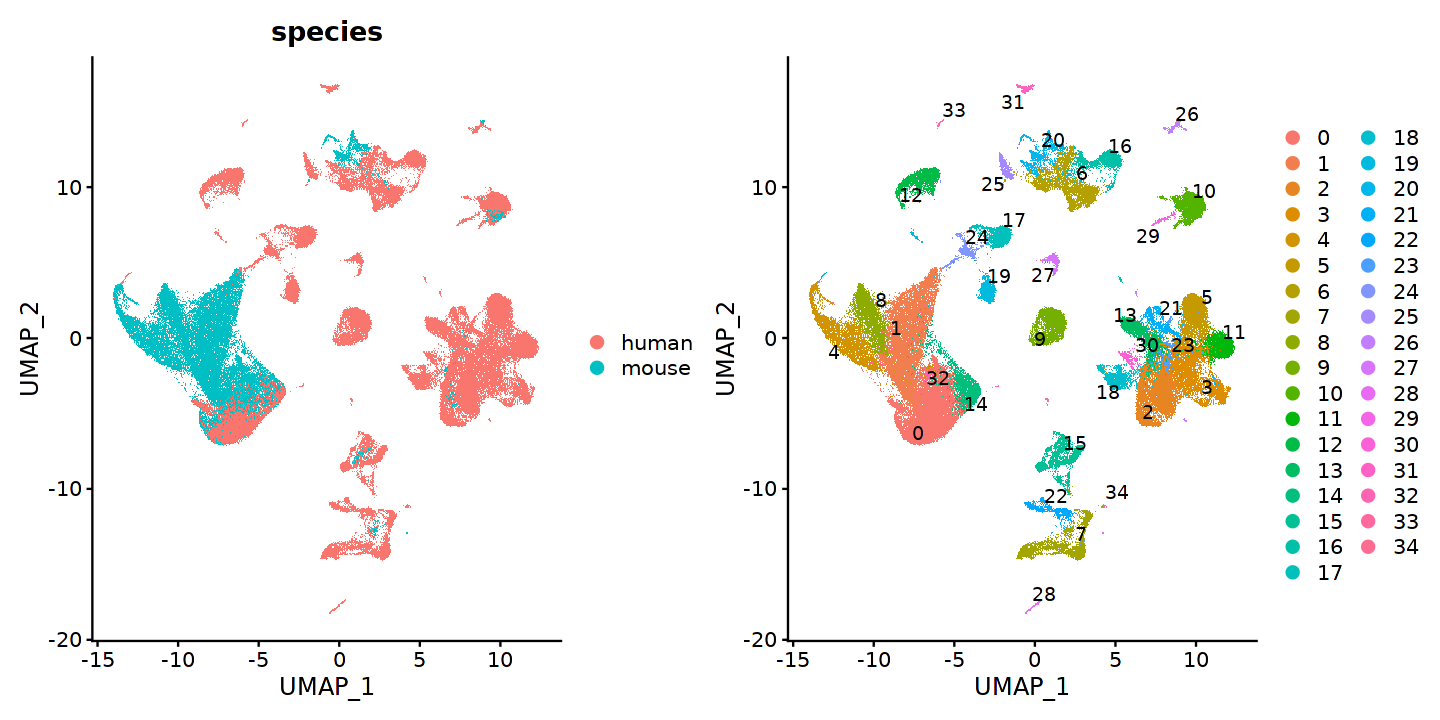

In [29]:
options(repr.plot.height=6, repr.plot.width=12, res=150 ) 
p1 <- DimPlot(mh, reduction = "umap", group.by = "species")
p2 <- DimPlot(mh, reduction = "umap", label = TRUE, repel = TRUE)
p1 + p2

In [43]:
mh.markers <- FindAllMarkers(mh, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34



In [46]:
mh.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,3.338691,1.000,0.295,0,0,MYCN
0,2.794687,1.000,0.810,0,0,H2AFZ
0,1.365764,0.997,0.326,0,1,EEF1A2
0,1.279011,1.000,0.546,0,1,STMN2
0,3.696282,0.831,0.307,0,2,IL7R
0,2.318338,0.589,0.282,0,2,ETS1
0,3.058164,0.364,0.141,0,3,XCL2
0,3.043899,0.329,0.173,0,3,XCL1
0,2.292383,0.966,0.225,0,4,TOP2A


In [1]:
mh.markers %>%
    group_by(cluster) %>%
    top_n(n = 3, wt = avg_log2FC) -> top10

ERROR: Error in mh.markers %>% group_by(cluster) %>% top_n(n = 3, wt = avg_log2FC): could not find function "%>%"


In [48]:
devtools::install_github("dill/emoGG")
library(emoGG)

emoji_search("birthday")

bday_plot <- data.frame(x = c(10, 15, 23, 27, 43, 56, 62, 76, 84, 92, 95), 
                        y = c(12, 71, 17, 84, 33, 70, 26, 82, 16, 26, 90))

ggplot() +
  geom_text(aes(x = 50, y = 50),label = "Happy Birthday!", 
            size = 10, color = "darkblue") +
  coord_cartesian(xlim = c(0, 100), ylim = c(0, 100)) +
  geom_emoji(data = bday_plot, aes(x = x, y = y), emoji="1f382", size = .1)


Warning message in system(cmd):
"system call failed: Cannot allocate memory"
Warning message in system(cmd):
"error in running command"
Warning message in utils::untar(tarfile, ...):
"'/bin/tar -xf '/tmp/Rtmpd0UH1E/file63aa7b2d7a4b.tar.gz' -C '/tmp/Rtmpd0UH1E/remotes63aa44f62a8e'' returned error code 127"


ERROR: Error: Failed to install 'emoGG' from GitHub:
  cannot popen '/bin/tar -tf '/tmp/Rtmpd0UH1E/file63aa7b2d7a4b.tar.gz'', probable reason 'Cannot allocate memory'
